# Notebook Overview

In this notebook, I will construct:


## Features

- ***Extract vegetation feature***
    - calculate the vegetation density around the outage location based on k-d tree 



- ***Extract spatial feature***
    - Divide bounded region into equal size grid



## Target

- ***Extract the outages***
    - Count the outages every 2 hours


In [1]:
#!pip install geopy
import os
import pickle
import pandas as pd
import numpy as np
import datetime
import math
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import spatial

%matplotlib inline
plt.style.use('seaborn-poster')

In [2]:
# Load library

# Helper functions

In [3]:
def to_Cartesian(lat, lon):
    '''
    function to convert latitude and longitude to 3D cartesian coordinates
    '''
    R = 6371 # radius of the Earth in kilometers

    x = R * math.cos(lat) * math.cos(lon)
    y = R * math.cos(lat) * math.sin(lon)
    z = R * math.sin(lat)
    return x, y, z

def deg2rad(degree):
    '''
    function to convert degree to radian
    '''
    rad = degree * 2*np.pi / 360
    return rad

def rad2deg(rad):
    '''
    function to convert radian to degree
    '''
    degree = rad/2/np.pi * 360
    return degree

def distToKM(x):
    '''
    function to convert cartesian distance to real distance in km
    '''
    R = 6371 # earth radius
    gamma = 2*np.arcsin(deg2rad(x/(2*R))) # compute the angle of the isosceles triangle
    dist = 2*R*math.sin(gamma/2) # compute the side of the triangle
    return dist

def kmToDIST(x):
    '''
    function to convert real distance in km to cartesian distance 
    '''
    R = 6371 # earth radius
    gamma = 2*np.arcsin(x/2./R) 
    
    dist = 2*R*rad2deg(sin(gamma / 2.))
    return dist

This function plot the correlation matrix 

In [4]:
# plot the correlation matrix
def diagonal_correlation_matrix(corr):
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

This function divides the spatial grid into smaller equal grids, we can tune the parameter `stepsize` (i.e size of small grid)

In [5]:
import shapely.geometry
import pyproj

# divide geographical region into equal sized grid and retrieving indexing position
def divide_area(north_west, south_east):

    # Set up projections
    p_ll = pyproj.Proj(init='epsg:4326')
    p_mt = pyproj.Proj(init='epsg:3857') # metric; same as EPSG:900913 ; 'epsg:3857' for Europe

    # Create corners of rectangle to be transformed to a grid
    nw = shapely.geometry.Point(north_west) # lon, lat
    se = shapely.geometry.Point(south_east) # lon, lat


    stepsize = 60000 # 60 km grid step size

    # Project corners to target projection
    s = pyproj.transform(p_ll, p_mt, nw.x, nw.y) # Transform NW point to 3857
    e = pyproj.transform(p_ll, p_mt, se.x, se.y) # .. same for SE

    # Iterate over 2D area
    gridpoints = []
    x = s[0]
    while x < e[0]:
        y = s[1]
        while y < e[1]:
            p = shapely.geometry.Point(pyproj.transform(p_mt, p_ll, x, y))
            gridpoints.append(p)
            y += stepsize
        x += stepsize
    
    locationlist = [(p.y, p.x) for p in gridpoints]
    
    areas = list(zip( locationlist[0:3], locationlist[5:8])) + list(zip( locationlist[4:7], locationlist[9:12]))

    #areas = dict(enumerate(areas, start=1))
    areas = {'area ' + str(idx) : e for idx, e in enumerate(areas,1)} 
    return areas

This function check if each lat/lon is within smaller equal grids and assigns a label to it.

In [6]:
# assign area to each lat/lon within that area
def extract_areas(row, areas):
    
    lat, lon = row
    for area, points in areas.items():

        point1, point2 = points

        max_lat, min_lat = max(point1[0], point2[0]), min(point1[0], point2[0])
        max_lon, min_lon = max(point1[1], point2[1]), min(point1[1], point2[1])
    
        if (lat >=  min_lat) and (lat <= max_lat) and (lon >=  min_lon) and (lon <= max_lon):
            return area

# Weather dataset

In [7]:
df = pd.read_pickle('./data/reflectivity_velocity.pkl')
df.head(n=3)

,time,lat,lon,alt_m,refl,velocity
0,2011-01-18 14:02:04,41.859160,-74.141444,2435.0,10.939068,-12.581346
1,2011-01-19 08:02:36,41.928513,-74.047238,2435.0,0.000000,0.000000
2,2011-01-19 11:59:32,41.814751,-74.085651,2435.0,12.096394,-1.115756


(array([-5.,  0.,  5., 10., 15., 20., 25.]),
 <a list of 7 Text xticklabel objects>)

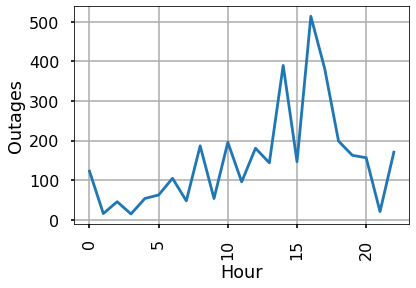

In [8]:
df['hour'] = df['time'].apply(lambda x :  x.hour)
df1 = df.groupby(['hour'])['time']
df1 = df1.describe()['count']
df1 = df1.reset_index()
df1 = df1.sort_values('hour', ascending=True)
plt.plot(df1['hour'], df1['count'])
plt.xlabel('Hour')
plt.ylabel('Outages')
plt.grid()
plt.xticks(rotation='vertical')

(array([ 0. ,  2.5,  5. ,  7.5, 10. , 12.5, 15. ]),
 <a list of 7 Text xticklabel objects>)

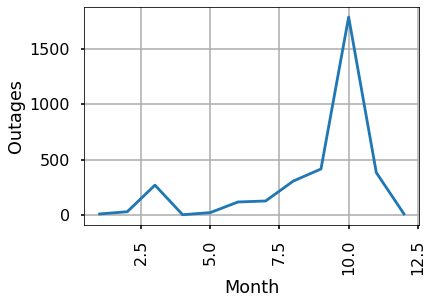

In [9]:
df['month'] = df['time'].apply(lambda x :  x.month)
df['month'] = df['month'].astype(int)
df2 = df.groupby(['month'])['time']
df2 = df2.describe()['count']
df2 = df2.reset_index()
df2 = df2.sort_values('month', ascending=True)
plt.plot(df2['month'], df2['count'])
plt.xlabel('Month')
plt.ylabel('Outages')
plt.grid()
plt.xticks(rotation='vertical')

# Extract vegetation feature

In [10]:
filename = './data/nlcd2011_usfs_percent_tree_cover_2km.txt'

df_tree =  pd.read_csv(filename, delimiter=",")

df_tree = df_tree.rename(columns={'X': 'longitude', 'Y': 'latitude', 'grid_code': 'coverage_percentage'})

print(df_tree.columns.tolist())
print(df_tree.columns.values)

df_tree.head(n=3)

['OBJECTID', 'coverage_percentage', 'longitude', 'latitude']
['OBJECTID' 'coverage_percentage' 'longitude' 'latitude']


,OBJECTID,coverage_percentage,longitude,latitude
0,1,43,-74.737386,42.617409
1,2,24,-74.712299,42.617409
2,3,45,-74.687212,42.617409


## KD-tree to find the closest points from a reference point in a group (Use geo-coordinates and real distances)



We use K-D Tree to query points by using the real distance between two points on the earth (instead of the Euclidean distance). 

- http://qingkaikong.blogspot.com/2017/12/use-k-d-tree-to-query-points-part-2-use.html

- https://github.com/qingkaikong/blog/blob/master/2017_33_kdtree_2_real_distance/kdtree-real-distance.ipynb


<img src='./image/kdtree-real-distance.png'>

In [11]:
def aggregate_tree_coverage(df_tree, lat_ref, lon_ref , n_closest=10):
    lats_1d = df_tree['latitude'].values
    lons_1d = df_tree['longitude'].values

    # convert the grid points and reference points to cartesian coordinates
    x, y, z = zip(*map(to_Cartesian, lats_1d, lons_1d))
    x_ref, y_ref, z_ref = to_Cartesian(lat_ref, lon_ref)
    
    # create the KD-tree using the 3D cartesian coordinates
    coordinates = list(zip(x, y, z))
    tree = spatial.cKDTree(coordinates)

    # get the cartesian distances from the 10 closest points
    dist, ix = tree.query((x_ref, y_ref, z_ref), n_closest)

    # print out the real distances in km
    #print(list(map(distToKM, dist)))
    
    avg_coverage = df_tree.loc[ix]['coverage_percentage'].mean()
    #avg_coverage = df_tree['coverage_percentage'].iloc[ix].mean()
    #print(avg_coverage)
    
    return avg_coverage

In [12]:
df['coverage_percentage'] = df[['lat','lon']].apply(lambda x: aggregate_tree_coverage(df_tree, 
                                                                                         x['lat'], 
                                                                                         x['lon'], 
                                                                                         n_closest=20), axis=1)

## Save dataframe into pickle

In [13]:
df.to_pickle('./data/composite_df.pkl')

# Extract Spatial feature

In [14]:
df = pd.read_pickle('./data/composite_df.pkl')

#check the time duration
print(f'Data is collected from {df.time.min()} to {df.time.max()}')

print(f'Dimension of data frame {df.shape}')

df.tail(n=3)

Data is collected from 2011-01-18 14:02:04 to 2012-12-30 17:55:25
Dimension of data frame (3472, 9)


,time,lat,lon,alt_m,refl,velocity,hour,month,coverage_percentage
3469,2012-12-27 12:01:05,41.931032,-73.953671,2439.0,3.682029,-7.616701,12,12,36.10
3470,2012-12-30 10:03:08,42.205727,-73.890111,2439.0,0.000000,0.000000,10,12,62.60
3471,2012-12-30 17:55:25,41.752131,-73.848375,2439.0,0.000000,0.000000,17,12,54.85


## Validate latitude and longitude 

In [15]:
def validate_lat_lon(lat, lon, lat_median, lon_median):
    if lat >= -90 and lat <= 90 and lon >= -180 and lon <= 180 and \
    abs(lat-lat_median < 10) and abs(lon-lon_median < 10):
        return 'Valid'
    else:
        return 'Invalid'
    
# check valid lat and lon
lat_median = np.median(df.lat)
lon_median = np.median(df.lon)

df['validLatLon'] = df.apply(lambda x : validate_lat_lon(x['lat'], x['lon'], lat_median, lon_median), axis=1)

# remove invalid lat and lon
df = df[df['validLatLon'] == 'Valid']
print(f'Dimension of data frame {df.shape}')

Dimension of data frame (3452, 10)


## Divide geographical region into equal sized grid

### Method 1

/Users/ducvu/anaconda3/envs/metis/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='bar')` instead of `Series.plot('bar',)`.
  # This is added back by InteractiveShellApp.init_path()


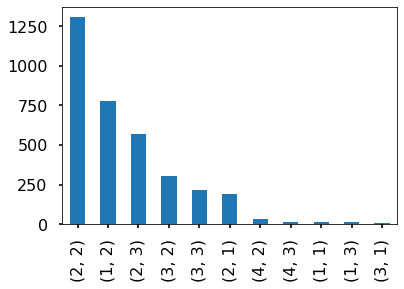

In [16]:
topLeft = (42.641400, -74.746500)
topRight = (42.641400, -73.425269)
bottomLeft = (41.196158, -74.746500)
bottomRight = (41.196158, -73.425269)

cols = np.linspace(bottomLeft[1], bottomRight[1], num=4)
rows = np.linspace(bottomLeft[0], topLeft[0], num=5)
df['col'] = np.searchsorted(cols, df['lon'])
df['row'] = np.searchsorted(rows, df['lat'])
df['area'] = list(zip(df['row'], df['col']))
df['area'].value_counts().plot('bar')

In [17]:
df = df.drop(['validLatLon', 'col', 'row'], axis=1)

### Method 2

/Users/ducvu/anaconda3/envs/metis/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='bar')` instead of `Series.plot('bar',)`.
  if __name__ == '__main__':


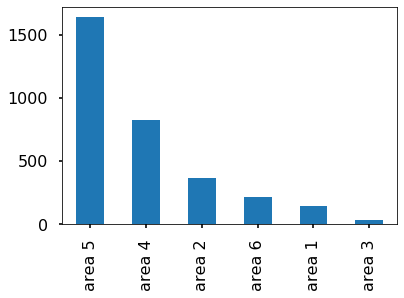

In [18]:
# project location coordinates -  Central Hudson Service Territory
north_west = (-74.746499999999969, 41.196157712000058 )
south_east = (-73.425268798999980, 42.641400000000033 )    

# divide whole area into smaller area
areas = divide_area(north_west, south_east)

df['areas'] = df[['lat', 'lon']].apply(lambda row: extract_areas(row, areas), axis=1)
df['areas'].value_counts().plot('bar')

# Extract the number of outages


## Count the number of blackout every 2 hours and join with original dataframe based on the timestamp 

In [19]:
weather = pd.read_pickle('./data/caidi_weather_outage.pkl')
weather = weather.rename(columns = {'Receive Datetime' : 'time', 'LONGITUDE' : 'lon', 'LATITUDE' : 'lat'})

                                                                                  
#check the time duration
print(f'Data is collected from {weather.time.min()} to {weather.time.max()}')

#check the dimension of dataset
print(f'Dimension of data frame {weather.shape}')

Data is collected from 2011-01-18 14:36:00 to 2016-12-18 19:53:12
Dimension of data frame (4323, 36)


/Users/ducvu/anaconda3/envs/metis/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='bar')` instead of `Series.plot('bar',)`.
  if __name__ == '__main__':


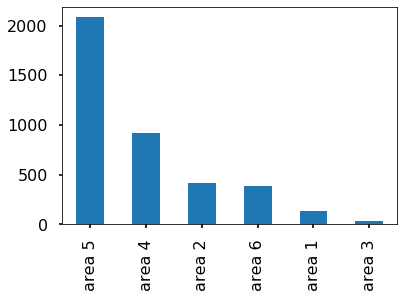

In [20]:
# project location coordinates -  Central Hudson Service Territory
north_west = (-74.746499999999969, 41.196157712000058 )
south_east = (-73.425268798999980, 42.641400000000033 )    

# divide whole area into smaller area
areas = divide_area(north_west, south_east)

weather['areas'] = weather[['lat', 'lon']].apply(lambda row: extract_areas(row, areas), axis=1)
weather['areas'].value_counts().plot('bar')

In [21]:
df_weather = weather.groupby([pd.Grouper(key='time',freq='2H'),weather['areas']]).size().reset_index(name='outage')
df_weather.head()

,time,areas,outage
0,2011-01-18 14:00:00,area 5,1
1,2011-01-19 08:00:00,area 5,1
2,2011-01-19 12:00:00,area 5,1
3,2011-02-18 22:00:00,area 5,1
4,2011-02-19 02:00:00,area 5,1


## Merge outage number based on a timestamp within the interval of 2 hours


Refer to :

- https://stackoverflow.com/questions/34880539/pandas-merging-based-on-a-timestamp-which-do-not-match-exactly

In [22]:
import numpy as np

# how close do sessions have to be to be considered equal? (in minutes)
threshold = 120 # in minutes

# half-threshold in nanoseconds
threshold_ns = threshold * 60 * 1e9

# compute "interval" to which each session belongs
df['interval'] = pd.to_datetime(np.round(df['time'].astype(np.int64) / threshold_ns) * threshold_ns)
df_weather['interval'] = pd.to_datetime(np.round(df_weather['time'].astype(np.int64) / threshold_ns) * threshold_ns)

# join
cols = [ 'areas', 'interval',]
df_final = df.merge(df_weather, on=cols, how='inner')


#check the dimension of dataset
print(f'Dimension of data frame {df_final.shape}')


# check if there is null value in dataframe
print(df_final.isnull().values.any())


# print name of all columns
print(f'The column names of data frame {list(df_final.columns)}') 


df_final = df_final[['lat', 'lon', 'alt_m', 'refl', 'velocity', 'coverage_percentage', 'areas','outage']]

Dimension of data frame (3126, 14)
False
The column names of data frame ['time_x', 'lat', 'lon', 'alt_m', 'refl', 'velocity', 'hour', 'month', 'coverage_percentage', 'area', 'areas', 'interval', 'time_y', 'outage']


In [23]:
df_final.head()

,lat,lon,alt_m,refl,velocity,coverage_percentage,areas,outage
0,41.859160,-74.141444,2435.0,10.939068,-12.581346,66.70,area 5,1
1,41.928513,-74.047238,2435.0,0.000000,0.000000,54.20,area 5,1
2,41.814751,-74.085651,2435.0,12.096394,-1.115756,61.15,area 5,1
3,41.864159,-74.045296,2435.0,-3.150364,0.000000,65.85,area 5,1
4,42.041518,-73.932509,2435.0,0.000000,0.000000,46.70,area 6,1


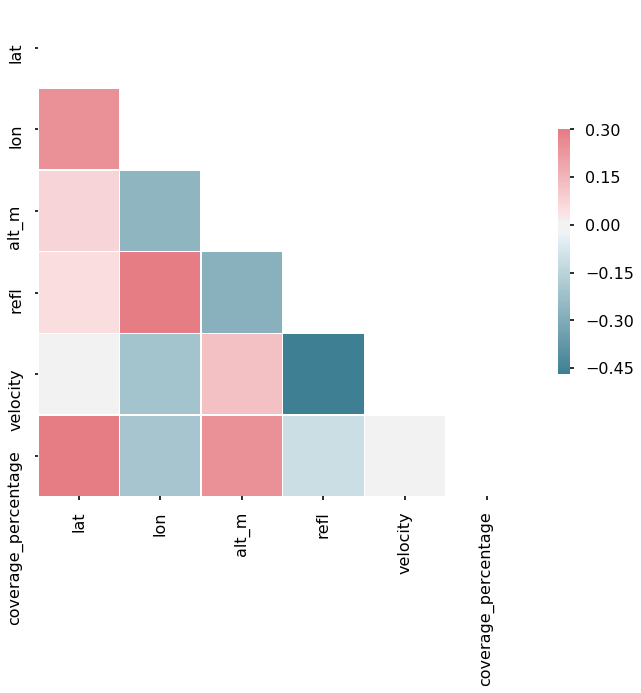

In [24]:
dataset = df[['lat', 'lon', 'alt_m', 'refl', 'velocity', 'coverage_percentage', 'areas']]

corr = dataset.corr()
#print(corr)
diagonal_correlation_matrix(corr)

# Save dataset 

In [25]:
df_final.to_csv('./data/data_input.csv')

***Reference*** 

- ***geospatial***
    - https://stackoverflow.com/questions/40342355/how-can-i-generate-a-regular-geographic-grid-using-python

    - https://gis.stackexchange.com/questions/16374/creating-regular-polygon-grid-in-postgis

    - https://gis.stackexchange.com/questions/48949/epsg-3857-or-4326-for-googlemaps-openstreetmap-and-leaflet

    - https://gis.stackexchange.com/questions/292117/dividing-geographical-region-into-equal-sized-grid-and-retrieving-indexing-posit